# ARIMAX

In [70]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import sys
sys.path.append('..')

In [72]:
import statslib as stb

import statsmodels.api as sm

import pandas as pd
from copy import deepcopy
import matplotlib as mpl
import matplotlib.pyplot as plt

figsize = (8*1.6, 8)

In [73]:
import warnings
warnings.filterwarnings("ignore")

# Data Set

In [74]:
stb.datasets.uschange.df.head()

,Consumption,Income,Production,Savings,Unemployment
date,,,,,
1970-03-31,0.615986,0.972261,-2.452700,4.810312,0.9
1970-06-30,0.460376,1.169085,-0.551525,7.287992,0.5
1970-09-30,0.876791,1.553271,-0.358708,7.289013,0.5
1970-12-31,-0.274245,-0.255272,-2.185455,0.985230,0.7
1971-03-31,1.897371,1.987154,1.909734,3.657771,-0.1


In [75]:
y = stb.datasets.uschange.df.Consumption

In [76]:
X = stb.datasets.uschange.df.drop('Consumption', axis=1)

# Design Matrix

In [77]:
DM = stb.DesignMatrix(y, X)

,Consumption,Income,Production,Savings,Unemployment
count,187.000000,187.000000,187.000000,187.000000,187.000000
mean,0.746471,0.717627,0.508060,1.222319,0.007487
std,0.655349,0.931356,1.544829,13.667434,0.375238
min,-2.274110,-4.265250,-6.851039,-68.788267,-0.900000
25%,0.419777,0.337765,0.055683,-4.217823,-0.200000
50%,0.772144,0.723721,0.657928,1.280017,0.000000
75%,1.089752,1.165022,1.305724,6.650723,0.100000
max,2.318295,4.536510,4.149574,50.757962,1.400000


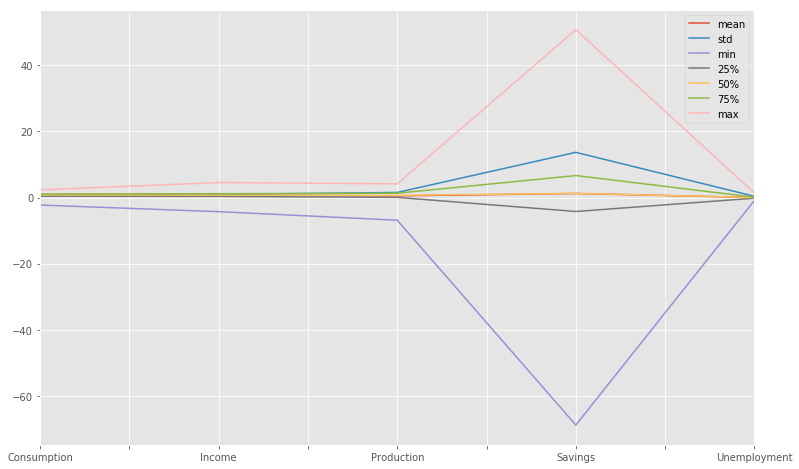

In [78]:
DM.describe()

In [79]:
DM.names

{'v': 'Consumption',
 'g1': 'Income',
 'g2': 'Production',
 'g3': 'Savings',
 'g4': 'Unemployment',
 'const': 'const'}

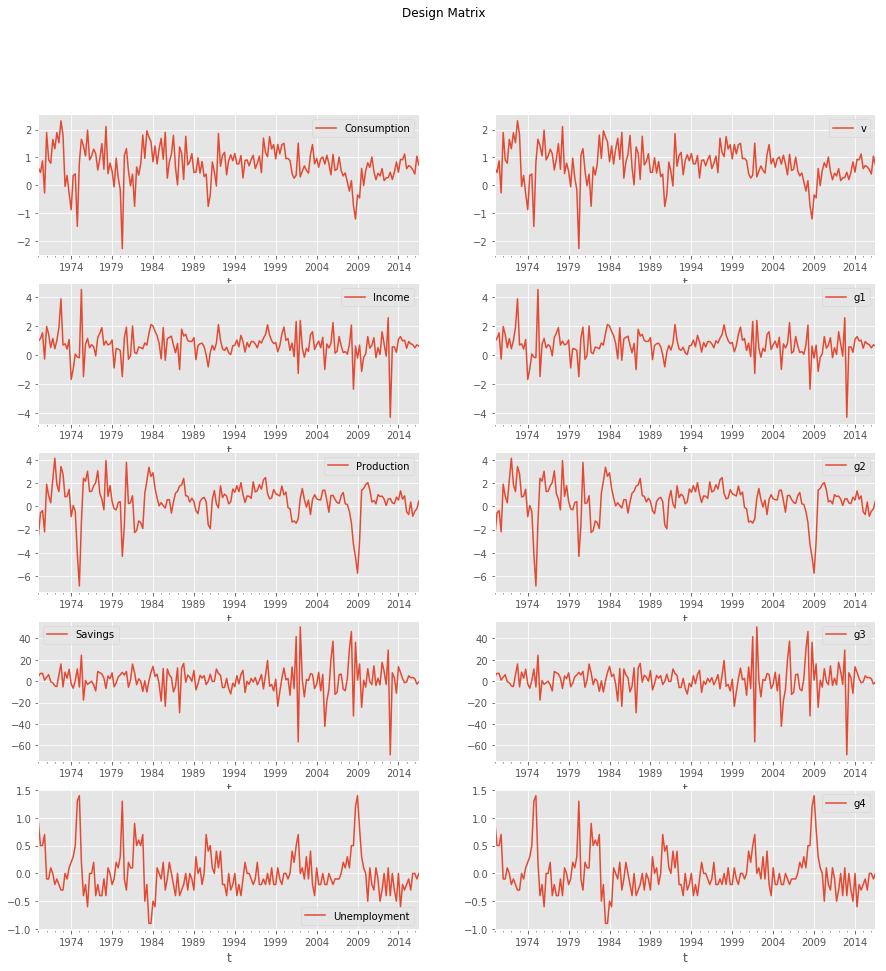

In [80]:
DM.plot()

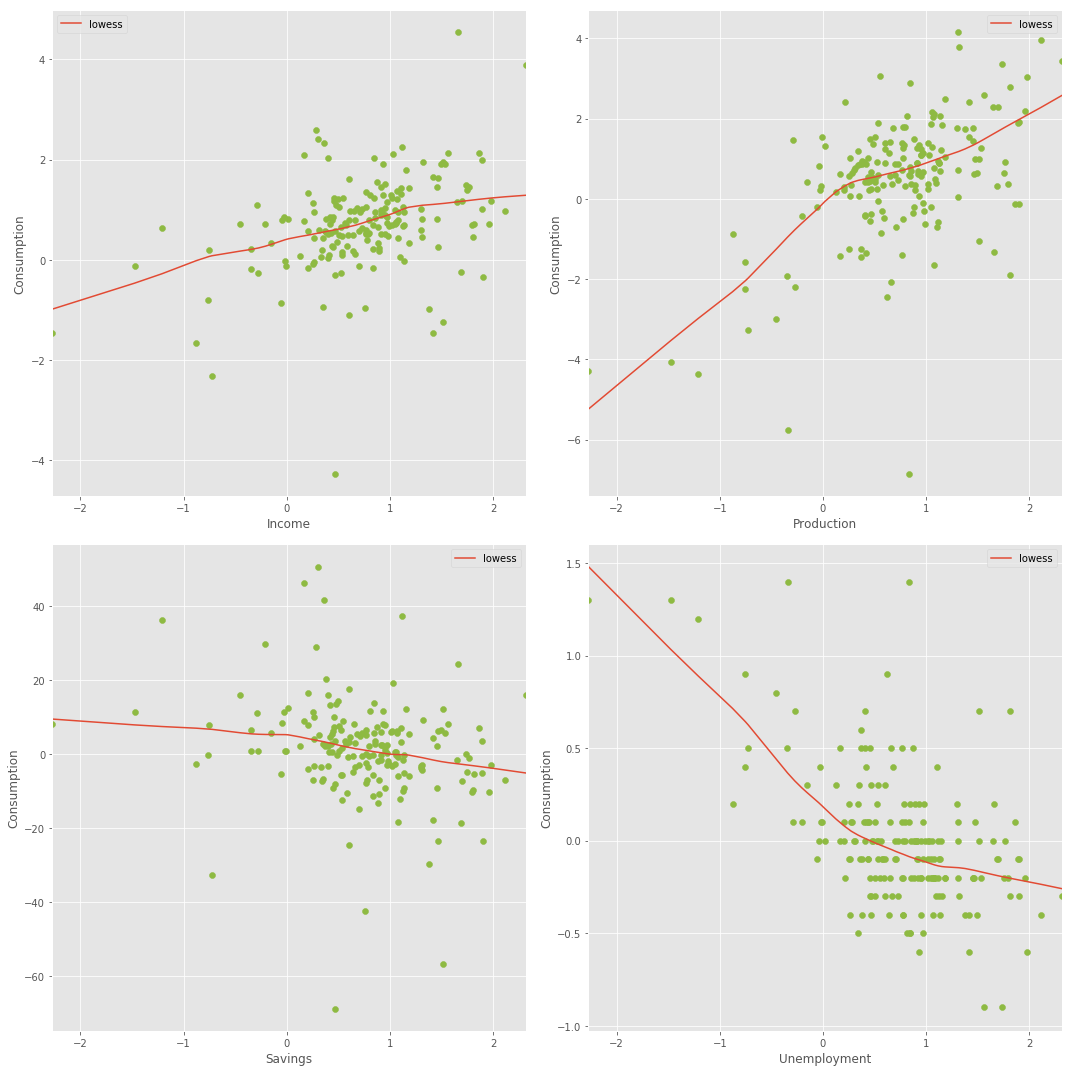

In [81]:
DM.plot_scatter_lowess()

# Grid Search

When fittind models, it is possible to increase the likelihood by adding parameters, but doing so may resut in overfitting. Both AIC, AICc and BIC attempt to resolve this problem by introducing a penalty term for the number of parameters in the model; the penalty term is larger in BIC than in AIC

## Information criterions

Likelihood function:
$$
L = p (x | \hat{\theta}, Model)
$$

### Akaike information criterion
$$
AIC = 2k - 2\ln(L)
$$


### Akaike with correction for small sample sizes

$$
AICc = AIC + \dfrac{2k^2 + 2k}{n-k-1}
$$

$ \\ $

*Hirotugu Akaike 1971*

### Bayesian information criterion

$$
BIC = k \ln(n) - 2\ln(L)
$$


where 
* $L$ - is maximum of the likelihood function
* $k$ - number of parameters estimated
* $n$ - number of data points

In [82]:
from itertools import product

grid = product(range(1,3), [0], range(1,3))

results = []
for elem in grid:
    try:
        gc = stb.GeneralCalibrator(sm.tsa.arima.ARIMA, 
                                       dict(order=elem, 
                                       trend='n', 
                                       enforce_stationarity=True))
        gm = stb.GeneralModel(gc, DM)
        gm.fit(range(10))
        results.append([elem, gm.fitted.aic])
    except:
        continue

pd.DataFrame(results, columns=['elem', 'metric']).sort_values(by=['metric'], ascending=True)

,elem,metric
2,"(2, 0, 1)",-35.259499
0,"(1, 0, 1)",-34.846358
1,"(1, 0, 2)",-30.989316
3,"(2, 0, 2)",-29.712975


In [83]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=6)
splits = [(train_idx, test_idx) for train_idx, test_idx in tscv.split(DM.dm.index)]

In [84]:
metric = stb.metrics.mean_absolute_percentage_error

CV_error: 0.8980 +/- 0.4935


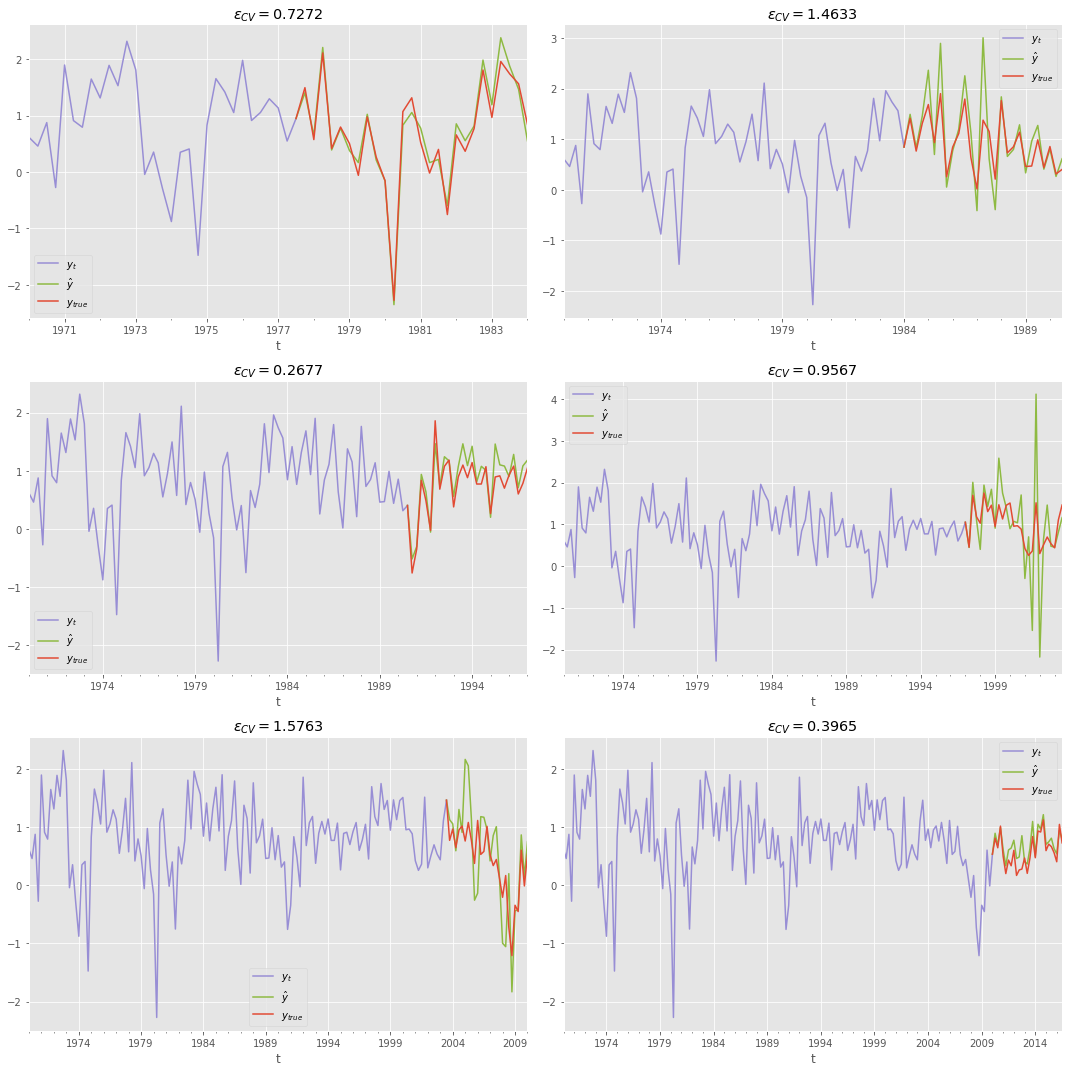

In [85]:
gc = stb.GeneralCalibrator(sm.tsa.arima.ARIMA, 
                               dict(order=(2,0,1), 
                               trend='n', 
                               enforce_stationarity=True))
gm = stb.GeneralModel(gc, DM)
cv = stb.CrossValidation(gm, splits, metric=metric)
cv_m, cv_std = cv.run()

# Final Model

In [86]:
gc = stb.GeneralCalibrator(sm.tsa.arima.ARIMA, 
                               dict(order=(2,0,1), 
                               trend='n', 
                               enforce_stationarity=True))
gm = stb.GeneralModel(gc, DM)

gm.fit(range(DM.n))

gm.forecast(range(DM.n))

print(gm.fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      v   No. Observations:                  187
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 -52.567
Date:                Thu, 18 Mar 2021   AIC                            123.135
Time:                        09:41:29   BIC                            152.215
Sample:                    03-31-1970   HQIC                           134.918
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2590      0.039      6.630      0.000       0.182       0.336
g1             0.7248      0.033     21.852      0.000       0.660       0.790
g2             0.0486      0.026      1.845      0.0

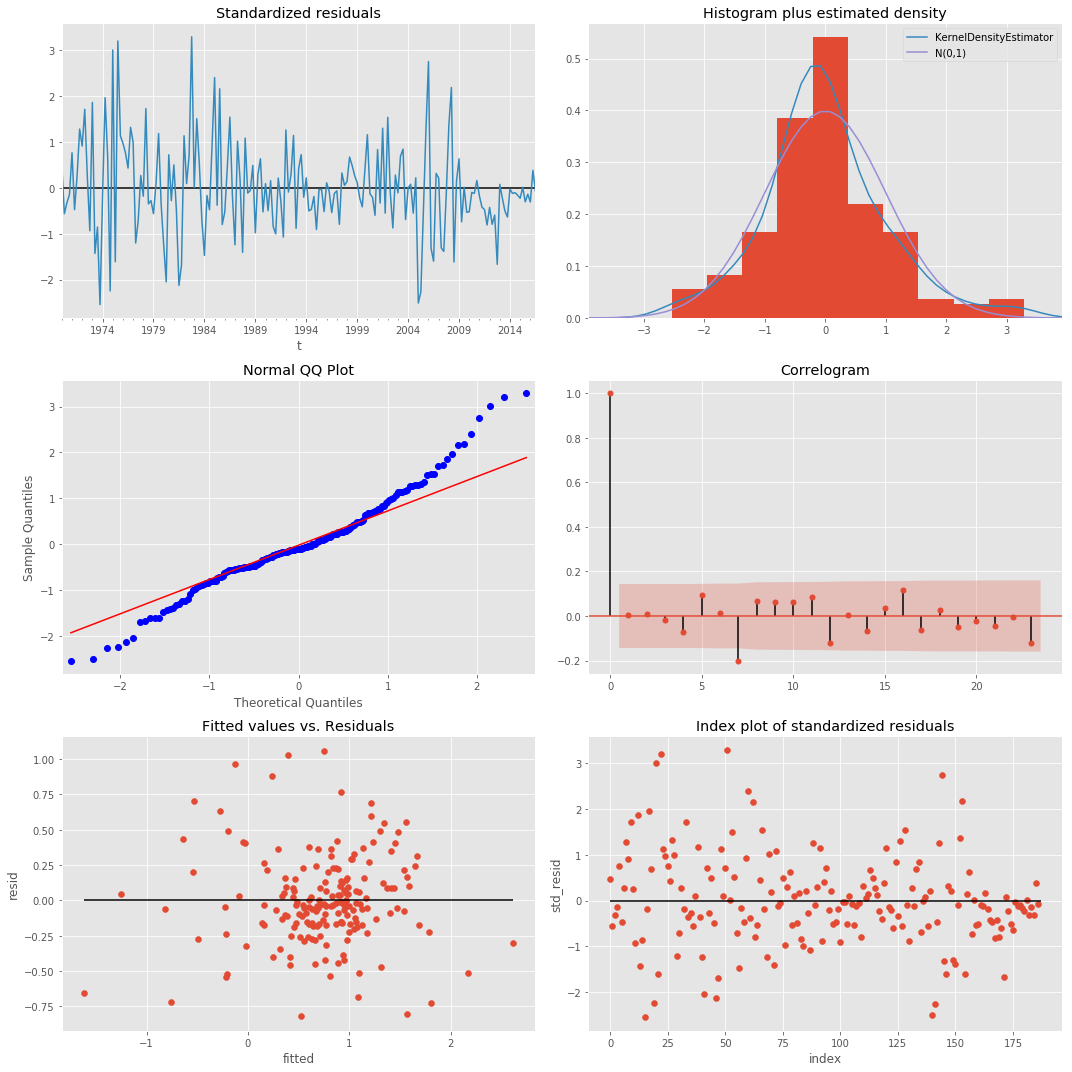

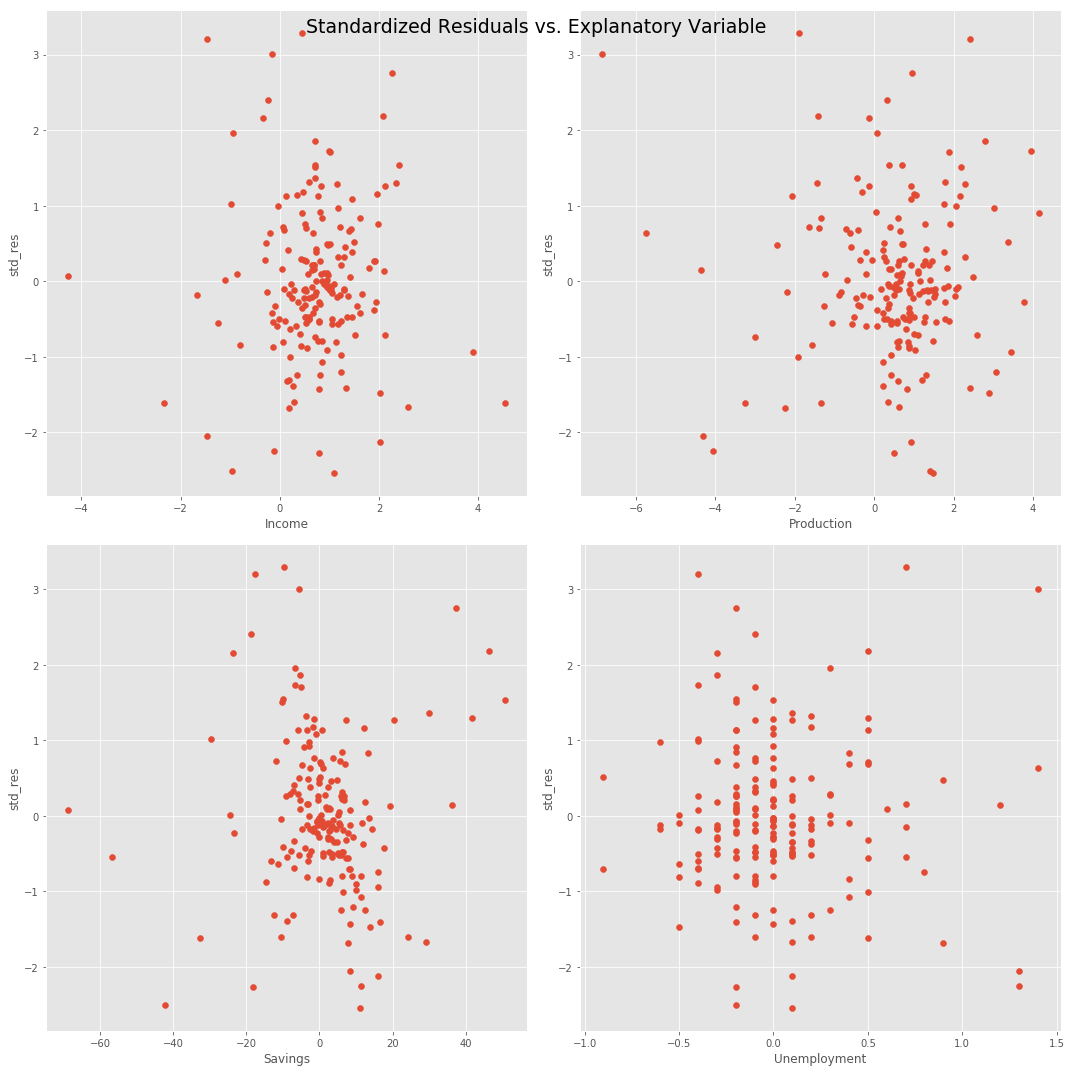

In [87]:
gm.plot_diagnostics()

**Jarque Bera test for 3d and 4th moment matching to the Normal one:**

In [88]:
stb.stat_tests.test_jarque_bera(gm.std_residuals)

H0: sample datasets have the skewness and kurtosis matching a normal distribution

Results of Jarque Bera Test:
Test Statistic    17.679693
p-value            0.000145
skew               0.462899
kurtosis           4.188255
dtype: float64

p-value 0.0001 is less alpha 0.01 => Reject H0


**Breusch Pagan Test for homoscedasticity**

In [89]:
stb.stat_tests.test_breusch_pagan(gm.residuals, gm.fitted.model.exog)

H0: series is homoskedastic

Results of BP Test:
Lagrange multiplier statistic    8.510493
p-value                          0.074570
f-value                          2.169469
f p-value                        0.074175
dtype: float64

Can NOT reject H0


# Diagnostics

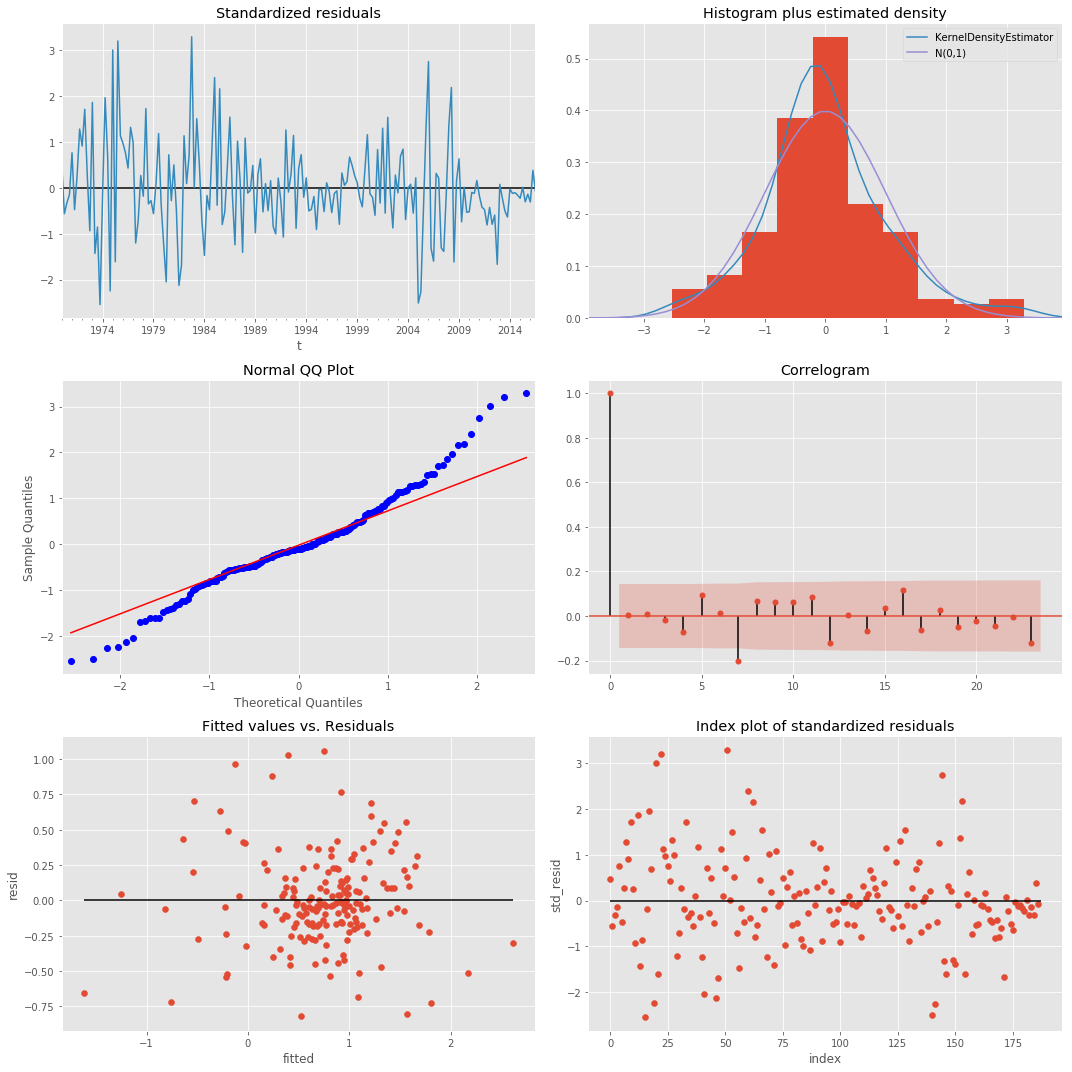

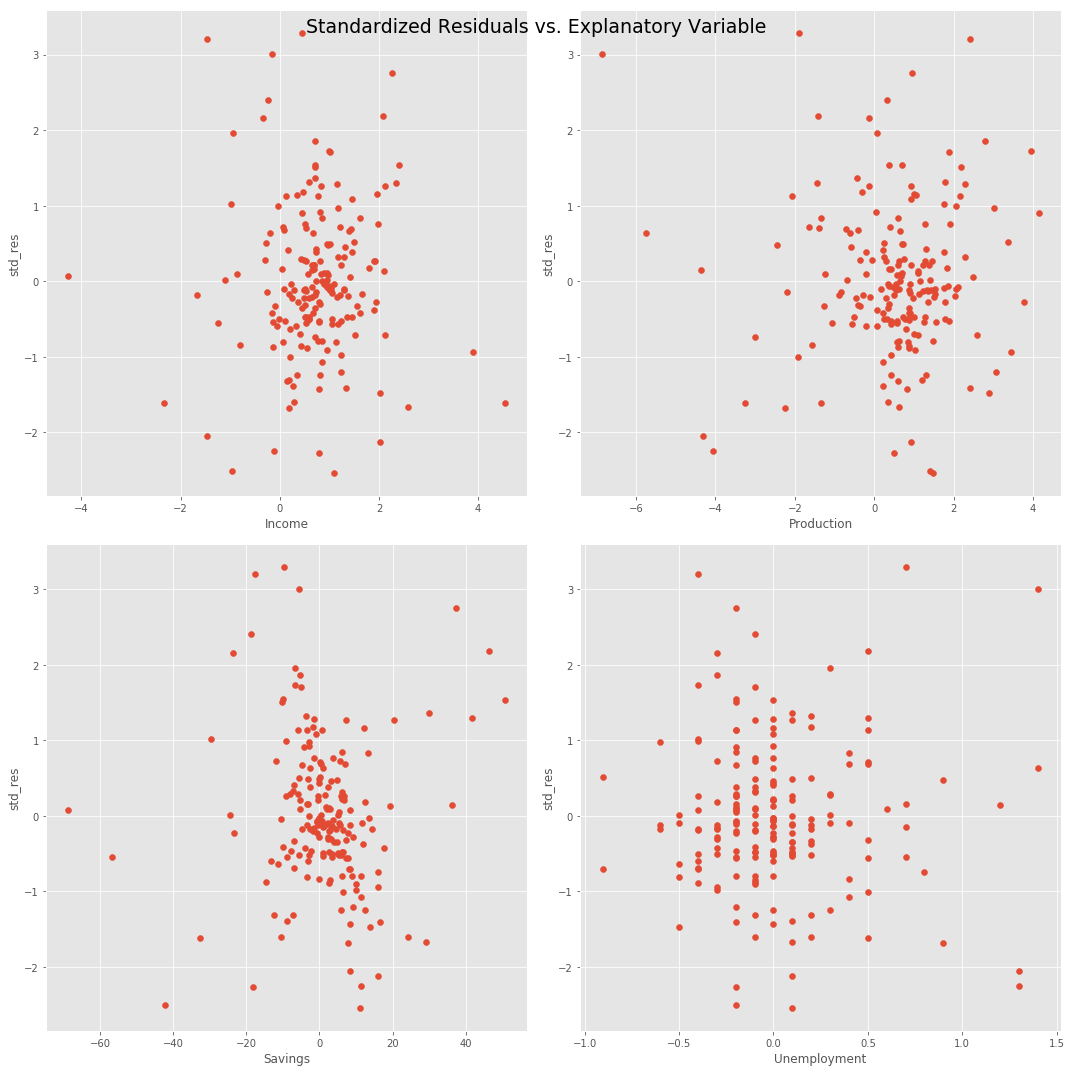

In [90]:
gm.plot_diagnostics()

**Jarque Bera test for 3d and 4th moment matching to the Normal one:**

In [91]:
stb.stat_tests.test_jarque_bera(gm.std_residuals)

H0: sample datasets have the skewness and kurtosis matching a normal distribution

Results of Jarque Bera Test:
Test Statistic    17.679693
p-value            0.000145
skew               0.462899
kurtosis           4.188255
dtype: float64

p-value 0.0001 is less alpha 0.01 => Reject H0


**Breusch Pagan Test for homoscedasticity**

In [92]:
stb.stat_tests.test_breusch_pagan(gm.residuals, gm.fitted.model.exog)

H0: series is homoskedastic

Results of BP Test:
Lagrange multiplier statistic    8.510493
p-value                          0.074570
f-value                          2.169469
f p-value                        0.074175
dtype: float64

Can NOT reject H0
